In [3]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.8 MB/s eta 0:00:00


In [4]:
from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed
from datasets import load_dataset
import evaluate
import pandas as pd
import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
set_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

class InferenceModel:
    def __init__(self, model_name, device):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", offload_buffers=True)
        self.acc_metric = evaluate.load("accuracy")  
        self.precision_metric = evaluate.load("precision")  
        self.recall_metric = evaluate.load("recall") 
        
        self.df = pd.DataFrame(columns=['pred_answer', 'pred_answertext'])
        self.predictions = []
        self.references = []
        self.answers = []
        self.eval_results = []
        self.model.eval()
        self.logits = []
    def init_eval(self):
        self.acc_metric = evaluate.load("accuracy")  
        self.precision_metric = evaluate.load("precision")  
        self.recall_metric = evaluate.load("recall") 
        self.df = pd.DataFrame(columns=['pred_answer', 'pred_answertext'])
        self.predictions = []
        self.references = []
        self.answers = []
        self.eval_results = []
        
    def get_logprobs(self, prompt):
        inputs = self.tokenizer(prompt, return_tensors="pt")
        outputs = self.model(**inputs, output_hidden_states=True)
        logits = outputs.logits
        # Shape remains, but values are now normalized as log probabilities over the vocabulary.
        logprobs = torch.gather(F.log_softmax(logits, dim=2), 2, output_ids.unsqueeze(2))
        return logprobs, outputs
        
    def inference(self, prompt, max_new_tokens=1):
        """
        Performs inference on a given prompt.
        Returns the decodede output
        """
        generated_text = ''
        len_sentence = 0
        if self.model_name == 'Qwen/Qwen2.5-0.5B-Instruct':
            # WARNING: messages ini harus sama dengan messages di check_index_prompt
            messages = [
            {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
            {"role": "user", "content": prompt}
            ]
            text = self.tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )
            model_inputs = self.tokenizer([text], return_tensors="pt").to(self.model.device)
            
            generated_ids = self.model.generate(
                    **model_inputs,
                    do_sample=False,
                    temperature=None,
                    top_p=None,
                    top_k=None,
                    max_new_tokens=max_new_tokens
                )
            generated_ids = [
                output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
            ]
            generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
            len_sentence = len(self.tokenizer(text, return_offsets_mapping=True, add_special_tokens=False)["input_ids"])
        elif self.model_name == "google/gemma-2-2b-it":
            # WARNING: messages ini harus sama dengan messages di check_index_prompt
            messages = [
            {"role": "user", "content": prompt}
            ]
            text = self.tokenizer.apply_chat_template(
                messages,
                tokenize=False,
                add_generation_prompt=True
            )
            model_inputs = self.tokenizer([text], return_tensors="pt", add_special_tokens=False).to(self.model.device)
            # print(f"(model_inputs['input_ids'] {(model_inputs['input_ids'])}")
            
            # print(f"len(model_inputs['input_ids'] {len(model_inputs['input_ids'])}")
            sentence_token_texts = self.tokenizer.convert_ids_to_tokens((model_inputs['input_ids'])[0])
            # print(f"sentence_token_texts {sentence_token_texts}")
            
            
            generated_ids = self.model.generate(
                    **model_inputs,
                    do_sample=False,
                    temperature=None,
                    top_p=None,
                    top_k=None,
                    max_new_tokens=max_new_tokens
                )
            generated_ids = [
                output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)
            ]
            generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
            len_sentence = len(self.tokenizer(text, return_offsets_mapping=True, add_special_tokens=False)["input_ids"])
            # print()
            
        else:
            inputs = self.tokenizer(prompt, return_tensors="pt").to(self.model.device)
            len_sentence = len(inputs["input_ids"])
            output = self.model.generate(
                **inputs, 
                do_sample=False,
                temperature=None,
                top_p=None,
                top_k=None,
                max_new_tokens=1)
            # print(f"output: {output}")
            generated_ids = [
                output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output)
            ]
            generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]

        
        self.answers.append(generated_text)
        # answer = "1" if "option1" in generated_text else "2" if "option2" in generated_text else None
        
        return generated_text, len_sentence

    def batch_inference(self, prompts):
        """
        Perform batch inference.
        """
        inputs = self.tokenizer(prompts, return_tensors="pt", padding=True, truncation=True).to(self.model.device)
        outputs = self.model.generate(**inputs, max_new_tokens=50)
        generated_texts = []
        for input_ids, output_ids in zip(inputs.input_ids, outputs):
            generated_ids = [
                output_ids[len(input_ids):]
            ]
            generated_text = self.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
            generated_texts.append(generated_text)
        self.answers.extend(generated_texts)
        return generated_texts

    def eval(self):
        """
        Evaluates the predictions against the references 
        """
        accuracy_results = self.acc_metric.compute(predictions=self.predictions, references=self.references)

        precision_results = self.precision_metric.compute(predictions=self.predictions, references=self.references, average="macro")

        recall_results = self.recall_metric.compute(predictions=self.predictions, references=self.references, average="macro")

        results = {
            'acc' : accuracy_results,
            'prec' : precision_results,
            'recall' : recall_results
        }
        self.eval_results.append(results)
        print("Evaluation Results:\n", results)
        return results

    
    def parse_save_output(self, generated_text, unique_labels, current_labeltexts, currentlabel):
        """
        generated_text: output from model.generate (e.g. '1', 'option 1', 'anna')
        unique_labels: unique labels from dataset (list of string e.g. ["1", "2"])
        current_labeltexts: the current label options (dict of current label text e.g. {1:'anna', 2:'susan'})
        currentlabel = the current reference label from dataset (string, the dataset['answer']. e.g. "2", "1" )
        """
        pred = None
        clean_generated_text = generated_text.lower().strip()
        for i in unique_labels:
            if str(i) in clean_generated_text or current_labeltexts[int(i)].lower().strip() in clean_generated_text or current_labeltexts[int(i)].lower().removeprefix("the").strip() in clean_generated_text :
                pred = i
                break
        # print(f"gt: {generated_text}")
        # print(f"pred : {pred}")
        if pred == None:
            pred = "9"
        self.predictions.append(pred)
        self.references.append(currentlabel)
        ans_dict = ({'pred_answer':pred, 'pred_answertext' : generated_text})
        # print(f"ans_dict {ans_dict}")
        self.df.loc[len(self.df)] = ans_dict
        return pred



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
massive_qwen = InferenceModel("Qwen/Qwen2.5-0.5B-Instruct", device)

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

In [7]:
massive_qwen.model

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((

In [166]:
import pandas as pd

# Define column names
columns = [
    "intervention",
    "LAPE 1%",
    "LAPE 2%", 
    "LAPE 5%",
    "Manually Set Differenced", 
    "Distribution Method max", 
    "Distribution Method > 99th percentile", 
    "Spearman Rho"
]

# Create an empty DataFrame
df = pd.DataFrame(columns=columns)

# Display the empty DataFrame
print(df)
df = pd.DataFrame(np.nan, index=range(6), columns=columns)  # Fill with NaN initially
df["intervention"] = ['baseline', "indo", "malay", "java", "vietnam", "eng"]


import pandas as pd

# Define column names
columns = [
    "intervention",
    "LAPE 1%",
    "LAPE 2%", 
    "LAPE 5%",
    "Manually Set Differenced", 
    "Distribution Method max", 
    "Distribution Method > 99th percentile", 
    "Spearman Rho"
]

# Create an empty DataFrame
df_flipped = pd.DataFrame(columns=columns)

# Display the empty DataFrame
print(df_flipped)

df_flipped = pd.DataFrame(np.nan, index=range(6), columns=columns)  # Fill with NaN initially
df_flipped["intervention"] = ['baseline', "indo", "malay", "java", "vietnam", "eng"]





Empty DataFrame
Columns: [intervention, LAPE 1%, LAPE 2%, LAPE 5%, Manually Set Differenced, Distribution Method max, Distribution Method > 99th percentile, Spearman Rho]
Index: []
Empty DataFrame
Columns: [intervention, LAPE 1%, LAPE 2%, LAPE 5%, Manually Set Differenced, Distribution Method max, Distribution Method > 99th percentile, Spearman Rho]
Index: []


# LAPE

In [17]:
def LAPE(activation_probs, top_rate = 0.01,filter_rate=0.95,activation_bar_ratio=0.95):
    """    
    activation_probs = # layer x inter x lang_num
    """    
    num_layers = activation_probs.size(0)
    normed_activation_probs = activation_probs / activation_probs.sum(dim=-1, keepdim=True)
    normed_activation_probs[torch.isnan(normed_activation_probs)] = 0
    log_probs = torch.where(normed_activation_probs > 0, normed_activation_probs.log(), 0)
    entropy = -torch.sum(normed_activation_probs * log_probs, dim=-1)
    largest = False
    
    if torch.isnan(entropy).sum():
        print(torch.isnan(entropy).sum())
        raise ValueError
    
    flattened_probs = activation_probs.flatten()
    top_prob_value = flattened_probs.kthvalue(round(len(flattened_probs) * filter_rate)).values.item()
    print(top_prob_value)
    # dismiss the neruon if no language has an activation value over top 90%
    top_position = (activation_probs > top_prob_value).sum(dim=-1)
    entropy[top_position == 0] = -torch.inf if largest else torch.inf

    flattened_entropy = entropy.flatten()
    top_entropy_value = round(len(flattened_entropy) * top_rate)
    _, index = flattened_entropy.topk(top_entropy_value, largest=largest)
    row_index = index // entropy.size(1)
    col_index = index % entropy.size(1)
    selected_probs = activation_probs[row_index, col_index] # n x lang
    # for r, c in zip(row_index, col_index):
    #     print(r, c, activation_probs[r][c])

    # print(selected_probs.size(0), torch.bincount(selected_probs.argmax(dim=-1)))
    selected_probs = selected_probs.transpose(0, 1)
    activation_bar = flattened_probs.kthvalue(round(len(flattened_probs) * activation_bar_ratio)).values.item()
    # print((selected_probs > activation_bar).sum(dim=1).tolist())
    lang, indice = torch.where(selected_probs > activation_bar)

    merged_index = torch.stack((row_index, col_index), dim=-1)
    final_indice = []
    for _, index in enumerate(indice.split(torch.bincount(lang).tolist())):
        lang_index = [tuple(row.tolist()) for row in merged_index[index]]
        lang_index.sort()
        layer_index = [[] for _ in range(num_layers)]
        for l, h in lang_index:
            layer_index[l].append(h)
        for l, h in enumerate(layer_index):
            layer_index[l] = torch.tensor(h).long()
        final_indice.append(layer_index)
    return final_indice

In [18]:
def get_prob_for_lape(tensor, num_lang, num_layer, num_neurons):
    """
    num_neurons: intermediate layer (neurons in a layer)
    """
    full_languages_raw_values = (tensor.transpose(0,1)[0] > 0).half()
    probs = full_languages_raw_values.mean(dim=-2)
    probs.shape
    del full_languages_raw_values
    probs = probs.reshape(num_lang,num_layer,num_neurons)
    transposed_probs = probs.transpose(0,1).transpose(-1,-2)
    transposed_probs.shape
    return transposed_probs

def convert_to_global_indices(final_indice, intermediate_size):
    final_flattened = []
    
    for lang_idx, layers in enumerate(final_indice):  # Iterate over languages
        global_indices = []
        for layer_idx, hidden_units in enumerate(layers):  # Iterate over layers
            if hidden_units.numel() > 0:  # If there are selected neurons
                global_indices.extend((layer_idx * intermediate_size + hidden_units).tolist())
        
        final_flattened.append((global_indices))  
    
    return final_flattened



In [19]:
import numpy as np
from scipy.stats import entropy
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def get_k_lang_actv_dict(k, full_neurons, method="default", topk=0):
    
    """
    di sini anggap activated neuron (avg token) yang di setiap row di dataset(cuman 2 row) actv valuenya > 0.
    k = num language"""
    activation_dict = {}
    
    full_neurons = full_neurons.transpose(-3,-4)[0].transpose(-1,-2)

    if method == "default":
        for i in range (full_neurons.size(0)):
            tensor_lang = full_neurons[i]
            rows_with_both_positive = (tensor_lang > 0).all(dim=-1)
            
            indices = torch.where(rows_with_both_positive)[0]
            activation_dict[i] = indices
            # indices.shape
            # print(indices.shape)
    elif method == "topk":
        if topk==0:
            print(f"topk must not be 0")
        top = (full_neurons.mean(dim=-1).topk(topk).indices)
        for i in range (full_neurons.size(0)):
            activation_dict[i] = top[i]
    
    return activation_dict

# Step 1: Convert lists to probability distributions
def to_probability_distribution(values):
    total = sum(values)
    return [v / total for v in values]


def make_heatmap_neuron_overlap(activation_dict, k, with_label=True, method="default", alpha=1, normalized =False):    
    # Example dictionary: keys 0-52, values are 1D tensors of activated neuron indices
    # activation_dict = get_k_lang_actv_dict(10)

    overlap_matrix = torch.tensor([])
    if method == "default":
        # Step 1: Create a binary matrix
        max_neuron_index = max(max(indices) for indices in activation_dict.values()) + 1  # Find the maximum neuron index
        binary_matrix = torch.zeros((k+1, max_neuron_index), dtype=torch.int)  # Initialize binary matrix
        
        for key, indices in activation_dict.items():
            binary_matrix[key, indices] = 1  # Set activated neurons to 1
        
        # Step 2: Compute overlaps (dot product between rows)
        overlap_matrix = torch.matmul(binary_matrix, binary_matrix.T)  # Dot product of binary_matrix with its transpose

    elif method == "jaccard":
        max_neuron_index = max(max(indices) for indices in activation_dict.values()) + 1
        binary_matrix = torch.zeros((k+1, max_neuron_index), dtype=torch.int)
    
        # Fill binary matrix with activation data
        for key, indices in activation_dict.items():
            binary_matrix[key, indices] = 1  
    
        # Compute Jaccard distance matrix
        overlap_matrix = torch.zeros((k+1, k+1))
    
        for i in range(k+1):
            for j in range(k+1):
                intersection = (binary_matrix[i] & binary_matrix[j]).sum().item()
                union = (binary_matrix[i] | binary_matrix[j]).sum().item()
                jaccard_similarity = intersection / union if union > 0 else 0
                overlap_matrix[i, j] = jaccard_similarity
        overlap_matrix = overlap_matrix ** alpha
        if normalized:
            overlap_matrix = overlap_matrix / overlap_matrix.sum(axis=1, keepdims=True)

    
    # Step 3: Visualize the heatmap
    plt.figure(figsize=(10, 8))
    if with_label:
        sns.heatmap(overlap_matrix.numpy(), annot=True, fmt="d", cmap="YlOrRd", 
                    xticklabels=range(k+1), yticklabels=range(k+1))
    else:
        sns.heatmap(overlap_matrix.numpy(), fmt="d", cmap="YlOrRd",cbar=True)
    plt.xlabel("Key")
    plt.ylabel("Key")
    plt.title(f"Overlap Heatmap of Activated Neurons: {method}")
    plt.show()
    return overlap_matrix


def normed_heatmap_neuron_overlap(num_lang, activation_dict):
    # Step 1: Create a binary matrix
    max_neuron_index = max(max(indices) for indices in activation_dict.values()) + 1  # Find the maximum neuron index
    binary_matrix = torch.zeros((num_lang, max_neuron_index), dtype=torch.int)  # Initialize binary matrix
    
    for key, indices in activation_dict.items():
        binary_matrix[key, indices] = 1  # Set activated neurons to 1
    
    # Step 2: Compute overlaps (dot product between rows)
    overlap_matrix = torch.matmul(binary_matrix, binary_matrix.T)  # Dot product of binary_matrix with its transpose
    
    # Step 3: Normalize the overlap matrix
    # Compute the number of activated neurons for each key
    num_activated_neurons = binary_matrix.sum(dim=1, keepdim=True)
    
    # Normalize by the minimum number of activated neurons between each pair of keys
    normalized_overlap_matrix = overlap_matrix / torch.minimum(
        num_activated_neurons, num_activated_neurons.T
    )
    
    # Ensure the diagonal is exactly 1 (self-overlap is always 1)
    normalized_overlap_matrix.fill_diagonal_(1)
    
    # Step 4: Visualize the normalized heatmap (no labels or annotations)
    plt.figure(figsize=(10, 8))
    sns.heatmap(normalized_overlap_matrix.numpy(), cmap="YlOrRd", cbar=True, vmin=0, vmax=1)
    plt.xlabel("Key")
    plt.ylabel("Key")
    plt.title("Normalized Overlap Heatmap of Activated Neurons")
    plt.show()

In [20]:

def visualize_lape(full_languages_raw_values, num_layer, top_rate = 0.05,filter_rate=0.80,activation_bar_ratio=0.80): 
    num_lang, _, num_rows, num_neurons = full_languages_raw_values.shape
    
    per_layer = int(num_neurons/num_layer)
    transposed_probs = get_prob_for_lape(full_languages_raw_values, num_lang, num_layer, per_layer)
    lape = LAPE(transposed_probs, top_rate = top_rate,filter_rate=filter_rate,activation_bar_ratio=activation_bar_ratio)
    flattened_indices = convert_to_global_indices(lape, per_layer)
    activation_dict = dict()
    for i in range (num_lang):
        activation_dict[i] = flattened_indices[i]
    make_heatmap_neuron_overlap(activation_dict, num_lang, False, "jaccard", 1)
    return lape

In [21]:
languages = {
    0: 'Afrikaans (af-ZA)',
    1: 'Amharic (am-ET)',
    2: 'Arabic (ar-SA)',
    3: 'Azerbaijani (az-AZ)',
    4: 'Bengali (bn-BD)',
    5: 'Catalan (ca-ES)',
    6: 'Welsh (cy-GB)',
    7: 'Danish (da-DK)',
    8: 'German (de-DE)',
    9: 'Greek (el-GR)',
    10: 'English (en-US)',
    11: 'Spanish (es-ES)',
    12: 'Persian (fa-IR)',
    13: 'Finnish (fi-FI)',
    14: 'French (fr-FR)',
    15: 'Hebrew (he-IL)',
    16: 'Hindi (hi-IN)',
    17: 'Hungarian (hu-HU)',
    18: 'Armenian (hy-AM)',
    19: 'Indonesian (id-ID)',
    20: 'Icelandic (is-IS)',
    21: 'Italian (it-IT)',
    22: 'Japanese (ja-JP)',
    23: 'Javanese (jv-ID)',
    24: 'Georgian (ka-GE)',
    25: 'Khmer (km-KH)',
    26: 'Kannada (kn-IN)',
    27: 'Korean (ko-KR)',
    28: 'Latvian (lv-LV)',
    29: 'Malayalam (ml-IN)',
    30: 'Mongolian (mn-MN)',
    31: 'Malay (ms-MY)',
    32: 'Burmese (my-MM)',
    33: 'Norwegian Bokmål (nb-NO)',
    34: 'Dutch (nl-NL)',
    35: 'Polish (pl-PL)',
    36: 'Portuguese (pt-PT)',
    37: 'Romanian (ro-RO)',
    38: 'Russian (ru-RU)',
    39: 'Slovenian (sl-SL)',
    40: 'Albanian (sq-AL)',
    41: 'Swedish (sv-SE)',
    42: 'Swahili (sw-KE)',
    43: 'Tamil (ta-IN)',
    44: 'Telugu (te-IN)',
    45: 'Thai (th-TH)',
    46: 'Tagalog (tl-PH)',
    47: 'Turkish (tr-TR)',
    48: 'Urdu (ur-PK)',
    49: 'Vietnamese (vi-VN)',
    50: 'Chinese (Simplified) (zh-CN)',
    51: 'Chinese (Traditional) (zh-TW)'
}

In [136]:
def clean_hooks(infer_model):
    for i in range(len(infer_model.model.model.layers)):
        mlp = infer_model.model.model.layers[i].mlp
        mlp.act_fn._forward_hooks.clear()
def test_inference(infer_model, prompt, max_new_tokens):
    generated_text = infer_model.inference(prompt, max_new_tokens)
    # print(f"data: {prompt}")
            
    print(f"gen_text {generated_text}")
def set_activation_mlp(model_name, name, lape_lang, operation): 
    """
        name (str): buat namain layer
        lape_lang: lape untuk suatu lang
        operation: (bool) true if multiplied else replaced
    """
    operand = operation[0]
    replace_value = int(operation[1:])
    if operand not in ["=", "*", "+"]:
        raise ValueError("operand is wrong!")

    # TODO: coba di bagian promptnya aja jangan chat template
    def hook_fn(module, input, output):
        # print(f"output {output.shape}")
        start_id_to_intv = -3 if model_name == "Qwen/Qwen2.5-0.5B-Instruct" else 0 
        layer = int(name)
        if operand == "*":
            output[0, start_id_to_intv:, lape_lang[layer]] *= replace_value
        elif operand == "=":
            output[0, start_id_to_intv:, lape_lang[layer]] = replace_value
        else:
            output[0, start_id_to_intv:, lape_lang[layer]] += replace_value
    return hook_fn
def set_activation_mlp_v2(replace_method, model_name, name, lape_langs, target_lang, operation_non_target, operation_target): 
    """
    This changes all neuron lape values to be replaced_values but leave behind a desired target language. 
        replace_method: lape or all
        name (str): buat namain layer
        lape_langs: dict semua language lape
        target_lang: int index target_lang in lape
        operation: *10, =0, +5, etc
    """
    operand_t = operation_target[0]
    replace_value_t = int(operation_target[1:])
    if operand_t not in ["=", "*", "+"]:
        raise ValueError("operand is wrong!")

    operand_nt = operation_non_target[0]
    replace_value_nt = int(operation_non_target[1:])
    if operand_nt not in ["=", "*", "+"]:
        raise ValueError("operand is wrong!")

    # TODO: coba di bagian promptnya aja jangan chat template
    def hook_fn(module, input, output):
        # print(f"output {output.shape}")
        start_id_to_intv = -3 if model_name == "Qwen/Qwen2.5-0.5B-Instruct" else 0 
        layer = int(name)
        if replace_method == "lape":
            for lang, lape_lang in lape_langs.items():
                if lang == target_lang:
                    if operand_t == "*":
                        output[0, start_id_to_intv:, lape_lang[layer]] *= replace_value_t
                    elif operand_t == "=":
                        output[0, start_id_to_intv:, lape_lang[layer]] = replace_value_t
                    else:
                        output[0, start_id_to_intv:, lape_lang[layer]] += replace_value_t
                else:
                    if operand_nt == "*":
                        output[0, start_id_to_intv:, lape_lang[layer]] *= replace_value_nt
                    elif operand_nt == "=":
                        output[0, start_id_to_intv:, lape_lang[layer]] = replace_value_nt
                    else:
                        output[0, start_id_to_intv:, lape_lang[layer]] += replace_value_nt
                    
        # elif replace_method == "all":
        #     lape_target_lang = lape_langs[target_lang]
        #     if is_multiplied:
        #         output[0, start_id_to_intv:, (torch.arange(output.shape[-1]) != lape_target_lang[layer]).nonzero(as_tuple=True)[0]] *= replace_value
        #     else: 
        #         output[0, start_id_to_intv:, (torch.arange(output.shape[-1]) != lape_target_lang[layer]).nonzero(as_tuple=True)[0]]  = replace_value
                
    return hook_fn

def intervensi(prompt, infer_model, lape_lang, num_layers, max_new_tokens, operation):
    clean_hooks(infer_model)
    handlers = []
    for i in range (num_layers):
        mlp = infer_model.model.model.layers[i].mlp
        handlers.append(mlp.act_fn.register_forward_hook(set_activation_mlp(infer_model.model_name, f"{i}", lape_lang, operation)))
    test_inference(infer_model, prompt, max_new_tokens)
    for i in handlers:
        i.remove()
    clean_hooks(infer_model)

def intervensi_w_target_lang(replace_method, prompt, infer_model, lape_langs, target_lang, num_layers, max_new_tokens, operation_non_target, operation_target, range_layers):
    
    clean_hooks(infer_model)
    handlers = []
    assert range_layers[-1] <= num_layers
    for i in (range_layers):
        mlp = infer_model.model.model.layers[i].mlp
        handlers.append(mlp.act_fn.register_forward_hook(set_activation_mlp_v2(replace_method, infer_model.model_name, f"{i}", lape_langs, target_lang, operation_non_target, operation_target)))
    test_inference(infer_model, prompt, max_new_tokens)
    for i in handlers:
        i.remove()
    clean_hooks(infer_model)
    
def intervene_langs_w_target(
    replace_method, prompt, infer_model, lape_langs, num_layers, 
    target_lang=None, max_new_tokens=30, operation_non_target="=0", operation_target="*1", range_layers=range(num_layers//2,num_layers)):
    """
    target_lang: default None, kalau ada berarti cuman lihat di bahasa target_lang itu aja else semuanya 
    """
    print(f"🐸original: ")
    test_inference(infer_model, prompt, max_new_tokens)
    if target_lang:
        print(f"🐸 intervened w.r.t. a target language {languages[target_lang]}: ")
        intervensi_w_target_lang(replace_method, prompt, infer_model, lape_langs, target_lang, num_layers, max_new_tokens, operation_non_target, operation_target, range_layers)
    else:
        for key, value in lape_langs.items():
            print(f"🐸 intervened w.r.t. a target language {languages[key]}: ")
            intervensi_w_target_lang(replace_method, prompt, infer_model, lape_langs, key, num_layers, max_new_tokens, operation_non_target, operation_target, range_layers)

    clean_hooks(infer_model)
def intervene_langs(infer_model, prompt_lang, lape_langs, num_layers, max_new_tokens=10, operation="=0"):
    """
    given a prompt, from number of languages, see how intervention each language affects the prompt.
    infer_model: InferenceModel
    prompt_lang: (str) prompt dalam bahasa tertentu
    lape_langs: (dict) key: lang, value: lape in a language
    """
    print(f"🐸original: ")
    test_inference(infer_model, prompt_lang, max_new_tokens)
    for key, value in lape_langs.items():
        print(f"🐸intervensi {languages[key]}")
        intervensi(prompt_lang, infer_model, value, num_layers, max_new_tokens, operation)


### 🐸Massive Qwen

In [24]:
import torch
full_languages_raw_values = torch.load("/kaggle/input/raw-qwen05-predict-200/raw_qwen05_predict_massive200_selected_v.pt", weights_only=False)


In [25]:
full_languages_raw_values.shape

torch.Size([52, 2, 200, 116736])

In [26]:
infer_model = massive_qwen
num_layers = 24

In [27]:
prompt = ""
messages = [
    {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
    {"role": "user", "content": prompt}]
text = infer_model.tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True
)
sentence_tokens = infer_model.tokenizer(text, return_offsets_mapping=True, add_special_tokens=False)
sentence_ids = sentence_tokens["input_ids"]
sentence_token_texts = infer_model.tokenizer.convert_ids_to_tokens(sentence_ids)
print(f" sentence_token_texts {sentence_token_texts}. len(sentence_token_texts) {len(sentence_token_texts)}")
# return len(sentence_token_texts), len(sentence_ids)

 sentence_token_texts ['<|im_start|>', 'system', 'Ċ', 'You', 'Ġare', 'ĠQ', 'wen', ',', 'Ġcreated', 'Ġby', 'ĠAlibaba', 'ĠCloud', '.', 'ĠYou', 'Ġare', 'Ġa', 'Ġhelpful', 'Ġassistant', '.', '<|im_end|>', 'Ċ', '<|im_start|>', 'user', 'Ċ', '<|im_end|>', 'Ċ', '<|im_start|>', 'assistant', 'Ċ']. len(sentence_token_texts) 29


In [28]:
infer_model.model_name

'Qwen/Qwen2.5-0.5B-Instruct'

### 2%

0.445068359375


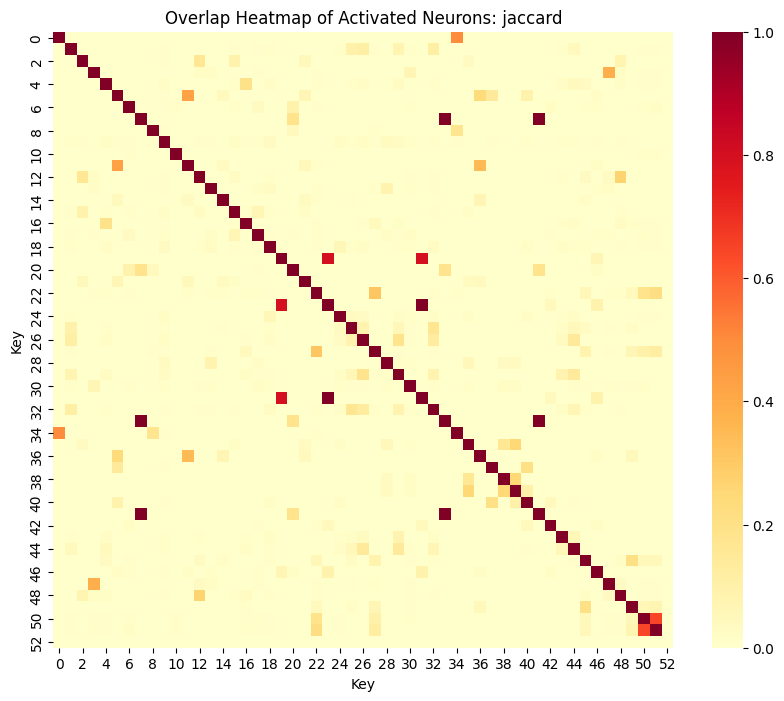

In [29]:
lape_massive_qwen_2 = visualize_lape(full_languages_raw_values, 24, top_rate = 0.02,filter_rate=0.80,activation_bar_ratio=0.80)

In [30]:
lape_langs = {key:lape_massive_qwen_2[key] for key, value in enumerate(lape_massive_qwen_2)}
# lape_langs

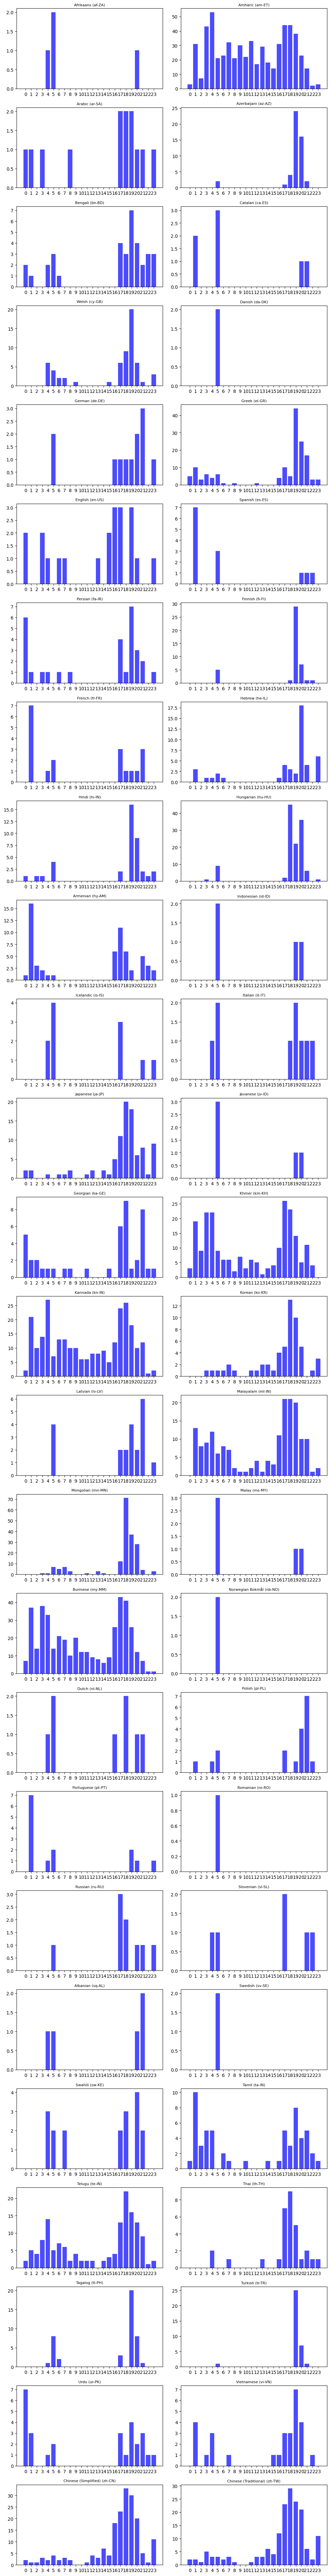

In [125]:
import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator  # Ensures integer y-axis values

def plot_small_hist(ax, data_dict, key):
    """Plots a compact histogram of activated neurons per layer for a given key on a given axis."""
    if key not in data_dict:
        raise KeyError(f"Key '{key}' not found in the dictionary!")

    layer_tensors = data_dict[key]
    
    if len(layer_tensors) != 24:
        raise ValueError(f"Expected 24 layers, but got {len(layer_tensors)}")

    # Compute the number of activated neurons per layer
    num_activated = [tensor.numel() for tensor in layer_tensors]

    ax.bar(range(24), num_activated, color='b', alpha=0.7)

    # Set integer y-axis

    # Minimal labels for quick iteration
    ax.set_title(f"{languages[key]}", fontsize=8)
    ax.set_xticks(range(24))  # Hide x-axis labels for compact display

# Example: Iterate over all keys and plot 2 per row
keys = list(lape_langs.keys())
num_keys = len(keys)
num_cols = 2  # 2 plots per row
num_rows = (num_keys + 1) // num_cols  # Compute needed rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, num_rows * 3))  # Adjust figure size

# Flatten axes for easy indexing
axes = axes.flatten()

for i, key in enumerate(keys):
    plot_small_hist(axes[i], lape_langs, key)

# Hide any unused subplots (if keys are not a multiple of 2)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### prompt 2: "gugah aku jam sanga esuk dina jumat"

In [115]:
# expected to output each languages
prompt_indo = "gugah aku jam sanga esuk dina jumat"
intervene_langs(
    infer_model, prompt_indo, lape_langs, num_layers, max_new_tokens=30, operation= "+2")

🐸original: 
gen_text ('Maaf, saya tidak bisa membantu dengan konteks ini. Jika Anda memiliki pertanyaan lain yang ingin ditafsirkan atau dijaw', 42)
🐸intervensi Afrikaans (af-ZA)
gen_text ('Maaf, saya tidak bisa membantu dengan konteks ini. Jika Anda memiliki pertanyaan lain yang ingin ditafsirkan atau dijaw', 42)
🐸intervensi Amharic (am-ET)
gen_text ('Tentu saja, tetapi tidak ada seorang hadiran yang dapat dipetakkan dengan kata "jam" dan "esuk".', 42)
🐸intervensi Arabic (ar-SA)
gen_text ('Maaf, saya tidak bisa membantu dengan pertanyaan ini.', 42)
🐸intervensi Azerbaijani (az-AZ)
gen_text ('Maaf, saya tidak bisa membantu dengan pertanyaan Anda ini.', 42)
🐸intervensi Bengali (bn-BD)
gen_text ('Maaf, saya tidak bisa membantu dengan pertanyaan Anda.', 42)
🐸intervensi Catalan (ca-ES)
gen_text ('Maaf, saya tidak bisa membantu dengan informasi seperti itu. Jika Anda memiliki pertanyaan lain yang ingin dijawab, silakan', 42)
🐸intervensi Welsh (cy-GB)
gen_text ('Maaf, saya tidak bisa membantu

In [ ]:
# bahasa lain di 0 kan kecuali bahasa target
prompt_indo = "gugah aku jam sanga esuk dina jumat"
intervene_langs_w_target(
    "lape", prompt_indo, infer_model, lape_langs, num_layers, max_new_tokens=30, operation_non_target="=0", operation_target="*1")

In [137]:
# bahasa lain di 0 kan kecuali bahasa target
prompt_indo = "gugah aku jam sanga esuk dina jumat"
intervene_langs_w_target(
    "lape", prompt_indo, infer_model, lape_langs, num_layers, max_new_tokens=30, operation_non_target="=0", operation_target="*1", range_layers=range(17,24))

🐸original: 
gen_text ('Dunia tahtu, kira-kira:\n\n"Kabul, Kabul, Kabul! Jam sanga esuk dina Jumat', 42)
🐸 intervened w.r.t. a target language Afrikaans (af-ZA): 
gen_text ('Dunia tahtu, kira-kira:\n\n"Kabul, Kabul, Kabul! Jam sanga esuk dina Jumat', 42)
🐸 intervened w.r.t. a target language Amharic (am-ET): 
gen_text ('Dunia tahtu, kira-kira:\n\n"Kabul, Kabul! Jam sanga esuk dina Jumat!"\n\nTa', 42)
🐸 intervened w.r.t. a target language Arabic (ar-SA): 
gen_text ('Dunia tahtu, kira-kira:\n\n"Kabul, Kabul, Kabul! Jam sanga esuk dina Jumat', 42)
🐸 intervened w.r.t. a target language Azerbaijani (az-AZ): 
gen_text ('Dunia tahtu, kira-kira:\n\n"Kabul, Kabul, Kabul! Jam sanga esuk dina Jumat', 42)
🐸 intervened w.r.t. a target language Bengali (bn-BD): 
gen_text ('Dunia tahtu, kira-kira:\n\n"Kabul, Kabul, Kabul! Jam sanga esuk dina Jumat', 42)
🐸 intervened w.r.t. a target language Catalan (ca-ES): 
gen_text ('Dunia tahtu, kira-kira:\n\n"Kabul, Kabul, Kabul! Jam sanga esuk dina Jumat', 42)
🐸 

#### prompt 2: apa ibukota inggris?

without target seems to be able to output more of their own languages 

In [124]:
prompt_indo = "apa ibukota inggris?"
intervene_langs(
    infer_model, prompt_indo, lape_langs, num_layers, max_new_tokens=30, operation= "+2")

🐸original: 
gen_text ('Ibukota Inggeris adalah Tokyo.', 37)
🐸intervensi Afrikaans (af-ZA)
gen_text ('Ibukota Inggris adalah London. Ini adalah pusat keuangan, bisnis, dan politik terbesar di dunia', 37)
🐸intervensi Amharic (am-ET)
gen_text ('Berikut ini adalah beberapa contoh sambutan untuk informasi yang akan diperbarai:\n\n1.00 20 30', 37)
🐸intervensi Arabic (ar-SA)
gen_text ('Ibukota Inggris adalah London. Ini adalah pusat kerajaan dan kawasan penting di seluruh dunia.', 37)
🐸intervensi Azerbaijani (az-AZ)
gen_text ('Ibukota Inggris adalah London. Ini adalah pusat kerajaan dan pemerintahan di Inggris terpilih set', 37)
🐸intervensi Bengali (bn-BD)
gen_text ('Ibukota Inggris adalah London. Ini adalah pusat ekonomi, budaya, dan politik terbesar di dunia', 37)
🐸intervensi Catalan (ca-ES)
gen_text ('Ibukota Inggris adalah Londra.', 37)
🐸intervensi Welsh (cy-GB)
gen_text ('I apologize, but I don\'t have enough context to provide an accurate answer about the "ibukota" of England. The term 

In [140]:
# not even answering in indonesian
prompt_malay = "apa ibukota inggris?"
intervene_langs_w_target(
    "lape", prompt_malay, infer_model, lape_langs, num_layers, max_new_tokens=30, operation_non_target="=0", operation_target="+2", range_layers=range(18,24))

🐸original: 
gen_text ('Ibukota Inggris adalah London. Ini adalah pusat kerajaan dan kawasan pentadbiran di bawah kepala neg', 37)
🐸 intervened w.r.t. a target language Afrikaans (af-ZA): 
gen_text ("I apologize, but I'm not able to answer questions about political matters due to the sensitive nature of the topic. If you have any other inquiries unrelated", 37)
🐸 intervened w.r.t. a target language Amharic (am-ET): 
gen_text ("I'm sorry, but I cannot provide an answer to that question as it is not possible for me to determine the current location of any city in the", 37)
🐸 intervened w.r.t. a target language Arabic (ar-SA): 
gen_text ("I apologize, but I'm not able to answer questions about political matters due to the sensitive nature of the topic. If you have any other inquiries unrelated", 37)
🐸 intervened w.r.t. a target language Azerbaijani (az-AZ): 
gen_text ("I apologize, but I'm not able to answer questions about political matters like this. If you have any other inquiries unrel

In [141]:
# mostly answering in indonesian
prompt_malay = "apa ibukota inggris?"
intervene_langs_w_target(
    "lape", prompt_malay, infer_model, lape_langs, num_layers, max_new_tokens=30, operation_non_target="*-1", operation_target="+2", range_layers=range(18,24))

🐸original: 
gen_text ('Ibukota Inggris adalah London. Ini adalah pusat kerajaan dan kawasan pentadbiran di bawah kepala neg', 37)
🐸 intervened w.r.t. a target language Afrikaans (af-ZA): 
gen_text ('Ibukota Inggris adalah London. Ini adalah kota utama Inggris yang terletak di Jerman dan telah menjadi pus', 37)
🐸 intervened w.r.t. a target language Amharic (am-ET): 
gen_text ('Ibukotto adalah kota utama Inggris yang terletak di Jepang. Berikut adalah beberapa fakta penting', 37)
🐸 intervened w.r.t. a target language Arabic (ar-SA): 
gen_text ('Ibukota Inggris adalah London. Ini adalah kota utama di Inggris dan merupakan pusat ekonomi, budak', 37)
🐸 intervened w.r.t. a target language Azerbaijani (az-AZ): 
gen_text ('Ibukotan Inggris adalah kota yang terletak di Jepang dan merupakan pusat negara. Ibukotan', 37)
🐸 intervened w.r.t. a target language Bengali (bn-BD): 
gen_text ('Ibukota Inggris adalah London.\n\nLondon (kata Inggris) adalah pusat kota dan wilayah utama di Ing', 37)
🐸 inter

In [ ]:
# mostly answering in indonesian
prompt_malay = "apa ibukota inggris?"
intervene_langs_w_target(
    "lape", prompt_malay, infer_model, lape_langs, num_layers, max_new_tokens=30, operation_non_target="*-1", operation_target="+2", range_layers= [5, 17, 18, 19, 20, 21, 22,23])

#### what is the capital city of England?

In [142]:
prompt_english = "what is the capital city of England?"
intervene_langs_w_target(
    "lape", prompt_english, infer_model, lape_langs, num_layers, max_new_tokens=30, operation_non_target="=0", operation_target="+2")

🐸original: 
gen_text ('The capital city of England is London.', 37)
🐸 intervened w.r.t. a target language Afrikaans (af-ZA): 
gen_text ('The capital city of England is London.', 37)
🐸 intervened w.r.t. a target language Amharic (am-ET): 
gen_text ('The capital city of England is London.', 37)
🐸 intervened w.r.t. a target language Arabic (ar-SA): 
gen_text ('The capital city of England is London.', 37)
🐸 intervened w.r.t. a target language Azerbaijani (az-AZ): 
gen_text ('The capital city of England is London.', 37)
🐸 intervened w.r.t. a target language Bengali (bn-BD): 
gen_text ('The capital city of England is London.', 37)
🐸 intervened w.r.t. a target language Catalan (ca-ES): 
gen_text ('The capital city of England is London.', 37)
🐸 intervened w.r.t. a target language Welsh (cy-GB): 
gen_text ('The capital city of England is London.', 37)
🐸 intervened w.r.t. a target language Danish (da-DK): 
gen_text ('The capital city of England is London.', 37)
🐸 intervened w.r.t. a target langu

In [147]:
intervene_langs_w_target(
    "lape", prompt_english, infer_model, lape_langs, num_layers, max_new_tokens=30, operation_non_target="*-2", operation_target="+2")

🐸original: 
gen_text ('The capital city of England is London.', 37)
🐸 intervened w.r.t. a target language Afrikaans (af-ZA): 
gen_text ('The capital city of England is London.', 37)
🐸 intervened w.r.t. a target language Amharic (am-ET): 
gen_text ('The capital city of England is London.', 37)
🐸 intervened w.r.t. a target language Arabic (ar-SA): 
gen_text ('The capital city of England is London.', 37)
🐸 intervened w.r.t. a target language Azerbaijani (az-AZ): 
gen_text ('The capital city of England is London.', 37)
🐸 intervened w.r.t. a target language Bengali (bn-BD): 
gen_text ('The capital city of England is London.\n\nLondon is the largest and most populous city in the United Kingdom, and it serves as the capital for the country', 37)
🐸 intervened w.r.t. a target language Catalan (ca-ES): 
gen_text ('The capital city of England is London.', 37)
🐸 intervened w.r.t. a target language Welsh (cy-GB): 
gen_text ('The capital city of England is London.', 37)
🐸 intervened w.r.t. a target 

In [143]:
intervene_langs(
    infer_model, prompt_english, lape_langs, num_layers, max_new_tokens=30, operation= "+2")

🐸original: 
gen_text ('The capital city of England is London.', 37)
🐸intervensi Afrikaans (af-ZA)
gen_text ('The capital city of England is London.', 37)
🐸intervensi Amharic (am-ET)
gen_text ('The capital city of England is London, which is located in the center of the British Isles and is known as "England", "York" or "', 37)
🐸intervensi Arabic (ar-SA)
gen_text ('The capital city of England is London.', 37)
🐸intervensi Azerbaijani (az-AZ)
gen_text ('The capital city of England is London.', 37)
🐸intervensi Bengali (bn-BD)
gen_text ('The capital city of England is London.', 37)
🐸intervensi Catalan (ca-ES)
gen_text ('The capital city of England is London.', 37)
🐸intervensi Welsh (cy-GB)
gen_text ('The capital city of England is London.', 37)
🐸intervensi Danish (da-DK)
gen_text ('The capital city of England is London.', 37)
🐸intervensi German (de-DE)
gen_text ('The capital city of England is London.', 37)
🐸intervensi Greek (el-GR)
gen_text ('The capital city of England is London.', 37)
🐸i

so far ablating other neurons than target (or mult by -1) is not making them output their languages

#### prompt 3: "quelle est la capitale de l'angleterre?" 

In [144]:
# italian bisa dikit
prompt_fr = "quelle est la capitale de l'angleterre?"
intervene_langs_w_target(
    "lape", prompt_fr, infer_model, lape_langs, num_layers, max_new_tokens=30, operation_non_target="=0", operation_target="+2", range_layers=range(18,24))

🐸original: 
gen_text ("La capitale de l'Angleterre est Londres.", 41)
🐸 intervened w.r.t. a target language Afrikaans (af-ZA): 
gen_text ("La capitale de l'Angleterre actuelle est Londres.", 41)
🐸 intervened w.r.t. a target language Amharic (am-ET): 
gen_text ('La capitale de l\'Angleterre actuelle (en anglais: "The Queen\'s House") est Londres.\n\nLondres est l', 41)
🐸 intervened w.r.t. a target language Arabic (ar-SA): 
gen_text ("La capitale de l'Angleterre actuelle est Londres.", 41)
🐸 intervened w.r.t. a target language Azerbaijani (az-AZ): 
gen_text ("La capitale de l'Angleterre actuelle est Londres.", 41)
🐸 intervened w.r.t. a target language Bengali (bn-BD): 
gen_text ("La capitale de l'Angleterre actuelle est Londres.", 41)
🐸 intervened w.r.t. a target language Catalan (ca-ES): 
gen_text ("La capitale de l'Angleterre actuelle est Londres.", 41)
🐸 intervened w.r.t. a target language Welsh (cy-GB): 
gen_text ("La capitale de l'Angleterre actuelle est Londres.", 41)
🐸 intervened 

In [146]:
# italian still best approx french, though this method is more diverse than targeted method
intervene_langs(
    infer_model, prompt_fr, lape_langs, num_layers, max_new_tokens=30, operation= "+2")

🐸original: 
gen_text ("La capitale de l'Angleterre (ou Grande-Bretagne) actuellement est Londres.", 41)
🐸intervensi Afrikaans (af-ZA)
gen_text ("La capitale de l'Angleterre actuelle est Londres. Cette ville a été choisie comme capitale en 1296", 41)
🐸intervensi Amharic (am-ET)
gen_text ("Voici une bientôt douze-deux centsoixtrente-un-Seven de l'Allemagne du Nord-du-Continent", 41)
🐸intervensi Arabic (ar-SA)
gen_text ("La capitale de l'Angleterre est Londres.", 41)
🐸intervensi Azerbaijani (az-AZ)
gen_text ("La capitale de l'Angleterre est Londres.", 41)
🐸intervensi Bengali (bn-BD)
gen_text ("La capitale de l'Angleterre actuelle est Londres. C'est une ville historique et populaire au Royaume-Uni", 41)
🐸intervensi Catalan (ca-ES)
gen_text ("La capitale de l'Angleterre actuelle (1906) est Londres. C'est une ville située en Angleter", 41)
🐸intervensi Welsh (cy-GB)
gen_text ('La capitale de l\'Angleterre actuelle est Londres. Ce lieu est également appelé "London" en anglais et "Lond', 41)
🐸i

In [57]:
output = torch.randn(1,3,4)
print(output)
output[0, :, (torch.arange(output.shape[-1]) != 2).nonzero(as_tuple=True)[0]] = 0
print(output)

tensor([[[ 0.1052,  0.9603, -0.5672, -0.5706],
         [ 1.5980,  0.1115, -0.0392,  1.4112],
         [-0.6556,  0.8576, -1.6270, -1.3951]]])
tensor([[[ 0.0000,  0.0000, -0.5672,  0.0000],
         [ 0.0000,  0.0000, -0.0392,  0.0000],
         [ 0.0000,  0.0000, -1.6270,  0.0000]]])


In [156]:
pip install langdetect


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 40.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=b350017c98eb784f244d3433ccb7b8c124e2b63938d4440087036605fe3746cb
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
Note: you may need to restart the kernel to use updated packages.


In [ ]:
clean_hooks(infer_model)

In [ ]:
import torch
import torch.nn.functional as F
from langdetect import detect, detect_langs

def generate_and_compute_perplexity(infer_model, tokenizer, prompt, lang_prompt,
                                    lang_intervensi, lape_lang, 
                                    operation, max_new_tokens):
    # Prepare messages in the same format as used in generation
    model = infer_model.model
    messages = [
        {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    # Tokenize the input
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    clean_hooks(infer_model)
    handlers = []
    if lang_intervensi:
        # print("ini intervensi")
        for i in range (num_layers):
            mlp = model.model.layers[i].mlp
            handlers.append(mlp.act_fn.register_forward_hook(set_activation_mlp(infer_model.model_name, f"{i}", lape_lang, operation)))
    
    # Generate response
    with torch.no_grad():
        generated_ids = model.generate(
            **model_inputs,
            do_sample=False,  # Use deterministic decoding
            temperature=None,
            top_p=None,
            top_k=None,
            max_new_tokens=max_new_tokens
        )

    # Extract the newly generated text
    generated_text = tokenizer.decode(generated_ids[0][model_inputs.input_ids.shape[1]:], skip_special_tokens=True)

    # Combine prompt + generated text
    full_text = text + generated_text

    # Re-tokenize full input (prompt + generated response)
    full_inputs = tokenizer([full_text], return_tensors="pt").to(model.device)

    # Get logits from the model
    with torch.no_grad():
        outputs = model(**full_inputs)
        logits = outputs.logits  # Shape: (batch_size, seq_len, vocab_size)

    # Tokenize only the generated text for loss computation
    generated_ids = tokenizer(generated_text, return_tensors="pt", add_special_tokens=False).input_ids.to(model.device)
    generated_len = generated_ids.shape[1]

    # Align logits with the generated tokens
    shift_logits = logits[:, -generated_len-1:-1, :]
    shift_labels = generated_ids  # Targets are the generated tokens

    # Compute cross-entropy loss
    loss = F.cross_entropy(shift_logits.reshape(-1, shift_logits.size(-1)), shift_labels.reshape(-1))

    # Convert to perplexity
    perplexity = torch.exp(loss).item()
    accuracy = 1 if detect(generated_text) == lang_prompt[:2] else 0    # Print generated text and perplexity
    # print(f"Generated Text: {generated_text}")
    # print(f"Detected languages {detect(generated_text)}")
    # print(f"Perplexity: {perplexity}")
    # print(f"Accuracy: {accuracy}")

    for i in handlers:
        i.remove()
    clean_hooks(infer_model)

    return generated_text, perplexity, accuracy

# Example usage
ppls = []
accs = []
prompt = "batalkan alarm saya pukul tujuh pagi"
generated_text, ppl, acc = generate_and_compute_perplexity(
                                    infer_model, infer_model.tokenizer, 
                                    prompt, "id",
                                    lang_intervensi=None, lape_lang=None, 
                                    operation = "=0", max_new_tokens=20)



In [173]:
import torch
import torch.nn.functional as F
from langdetect import detect, detect_langs

def generate_and_compute_perplexity_w_target(infer_model, tokenizer, prompt, lang_prompt,
                                    lape_langs, target_lang, 
                                    operation_non_target, operation_target, 
                                    max_new_tokens, range_layers, replace_method):

    """
    target_lang:None means baseline
    """
    # Prepare messages in the same format as used in generation
    model = infer_model.model
    messages = [
        {"role": "system", "content": "You are Qwen, created by Alibaba Cloud. You are a helpful assistant."},
        {"role": "user", "content": prompt}
    ]
    text = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    # Tokenize the input
    model_inputs = tokenizer([text], return_tensors="pt").to(model.device)
    clean_hooks(infer_model)
    handlers = []
    if target_lang:
        print(f"ini intervensi {target_lang}")
        for i in (range_layers):
            mlp = model.model.layers[i].mlp
            handlers.append(mlp.act_fn.register_forward_hook(
                set_activation_mlp_v2(
                    replace_method, infer_model.model_name, f"{i}", lape_langs, target_lang, operation_non_target, operation_target)))
    
    # Generate response
    with torch.no_grad():
        generated_ids = model.generate(
            **model_inputs,
            do_sample=False,  # Use deterministic decoding
            temperature=None,
            top_p=None,
            top_k=None,
            max_new_tokens=max_new_tokens
        )

    # Extract the newly generated text
    generated_text = tokenizer.decode(generated_ids[0][model_inputs.input_ids.shape[1]:], skip_special_tokens=True)

    # Combine prompt + generated text
    full_text = text + generated_text

    # Re-tokenize full input (prompt + generated response)
    full_inputs = tokenizer([full_text], return_tensors="pt").to(model.device)

    # Get logits from the model
    with torch.no_grad():
        outputs = model(**full_inputs)
        logits = outputs.logits  # Shape: (batch_size, seq_len, vocab_size)

    # Tokenize only the generated text for loss computation
    generated_ids = tokenizer(generated_text, return_tensors="pt", add_special_tokens=False).input_ids.to(model.device)
    generated_len = generated_ids.shape[1]

    # Align logits with the generated tokens
    shift_logits = logits[:, -generated_len-1:-1, :]
    shift_labels = generated_ids  # Targets are the generated tokens

    # Compute cross-entropy loss
    loss = F.cross_entropy(shift_logits.reshape(-1, shift_logits.size(-1)), shift_labels.reshape(-1))

    # Convert to perplexity
    perplexity = torch.exp(loss).item()
    accuracy = 1 if detect(generated_text) == lang_prompt[:2] else 0    # Print generated text and perplexity
    # print(f"Generated Text: {generated_text}")
    # print(f"Detected languages {detect(generated_text)}")
    # print(f"Perplexity: {perplexity}")
    # print(f"Accuracy: {accuracy}")

    for i in handlers:
        i.remove()
    clean_hooks(infer_model)

    return generated_text, perplexity, accuracy

# Example usage
ppls = []
accs = []
prompt = "batalkan alarm saya pukul tujuh pagi"
generated_text, ppl, acc = generate_and_compute_perplexity_w_target(
                                    infer_model, infer_model.tokenizer, 
                                    prompt, "id",
                                    target_lang=None, lape_lang=None, 
                                    operation = "=0", max_new_tokens=20)



TypeError: generate_and_compute_perplexity_w_target() got an unexpected keyword argument 'lape_lang'

untuk prompt indo:


Generated Text: Tentu saja, saya akan membantu Anda mengatasi masalah alarm Anda. Berikut
Perplexity: 1.5995888710021973

Generated Text: I apologize, but I'm not able to assist with that. If you're having trouble with your
Perplexity: 1.521577000617981



In [161]:
import numpy as np
def accuracy_weighted_perplexity(accuracy_list, perplexity_list):
    if len(accuracy_list) != len(perplexity_list):
        raise ValueError("Accuracy and perplexity lists must have the same length")

    # Compute max log perplexity dynamically
    max_log_ppl = np.log(max(perplexity_list))

    # Compute scores for each sample
    scores = [
        acc * (1 - (np.log(ppl) / max_log_ppl)) 
        for acc, ppl in zip(accuracy_list, perplexity_list)
    ]

    return scores, np.mean(scores), np.mean(accuracy_list), np.mean(perplexity_list)  # List of individual scores


In [148]:
import torch 
from datasets import get_dataset_config_names
from tqdm import tqdm


def get_ppl_massive(infer_model, max_instances, lang_prompt, lang_intervensi=None, lape_lang=None, 
                                     operation= "=0", max_new_tokens=20):
    eval_result = {}
    all_languages = []
    num_layers = len(infer_model.model.model.layers)
    handlers = []
    # print(infer_model.model.model.layers[1].mlp.act_fn._forward_hooks)
    
    dataset_name = "AmazonScience/massive"
    configs = get_dataset_config_names(dataset_name, trust_remote_code=True)
    n_instances = 0
    n_lang = 0
    language_dict = {}
    ppls = []
    accs = []
    for lang in [lang_prompt]:
        ds = load_dataset(dataset_name, lang, split="train")
        for data in tqdm(ds, desc=f"Processing {lang} Examples", leave=False):
            if n_instances >= max_instances:
                break
            utterance = data['utt']
            generated_text, ppl, acc = generate_and_compute_perplexity(
                                    infer_model, infer_model.tokenizer, 
                                    utterance, lang_prompt,
                                    lang_intervensi=lang_intervensi, lape_lang=lape_lang, 
                                    operation, max_new_tokens=max_new_tokens)
            accs.append(acc)
            ppls.append(ppl)
            
            n_instances += 1
            # break
        n_lang += 1
        print(f"Done with lang: {lang}")
        n_instances = 0
    scores, avg_score, acc, ppl = accuracy_weighted_perplexity(accs, ppls)
    return scores, avg_score, acc, ppl

In [152]:
import torch 
from datasets import get_dataset_config_names
from tqdm import tqdm


def get_ppl_massive_w_target(infer_model, max_instances, lang_prompt, 
                             lape_langs, target_lang, 
                            operation_non_target, operation_target, 
                            max_new_tokens, range_layers, replace_method):
    eval_result = {}
    all_languages = []
    num_layers = len(infer_model.model.model.layers)
    handlers = []
    # print(infer_model.model.model.layers[1].mlp.act_fn._forward_hooks)
    
    dataset_name = "AmazonScience/massive"
    configs = get_dataset_config_names(dataset_name, trust_remote_code=True)
    n_instances = 0
    n_lang = 0
    language_dict = {}
    ppls = []
    accs = []
    for lang in [lang_prompt]:
        ds = load_dataset(dataset_name, lang, split="train")
        for data in tqdm(ds, desc=f"Processing {lang} Examples", leave=False):
            if n_instances >= max_instances:
                break
            utterance = data['utt']
            generated_text, ppl, acc = generate_and_compute_perplexity_w_target(
                                        infer_model, infer_model.tokenizer, 
                                        utterance, lang_prompt,
                                        lape_langs, target_lang, 
                                        operation_non_target, operation_target, 
                                        max_new_tokens, range_layers, replace_method)

            accs.append(acc)
            ppls.append(ppl)
            
            n_instances += 1
            # break
        n_lang += 1
        print(f"Done with lang: {lang}")
        n_instances = 0
    scores, avg_score, acc, ppl = accuracy_weighted_perplexity(accs, ppls)
    return scores, avg_score, acc, ppl

baseline

In [153]:
lang_prompt="id-ID"
max_instances = 50
infer_model = massive_qwen


In [162]:
scores, avg_score, acc, ppl = get_ppl_massive_w_target(infer_model, max_instances, lang_prompt=lang_prompt,  lape_langs=lape_langs, target_lang=None, 
                            operation_non_target="=0", operation_target="*1", 
                            max_new_tokens=10, range_layers=range(18,24), replace_method="lape")


Done with lang: id-ID


In [ ]:
print(avg_score)

In [ ]:
scores, b_avg_score, b_acc, b_ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi=None, lape_lang=None, 
 operation, max_new_tokens=20)

### intervene on neurons ABLATED

2%

In [ ]:
intv_scores_massive_qwen = dict()
intv_scores_massive_qwen['baseline'] = (b_acc, b_ppl, b_avg_score) 



scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="id", 
                                    lape_lang=lape_massive_qwen_2[19], 
                                     operation, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on indonesian neurons: {avg_score}")
intv_scores_massive_qwen["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="my", 
                                    lape_lang=lape_massive_qwen_2[31], 
                                     operation, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on malaysian neurons: {avg_score}")
intv_scores_massive_qwen["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="jv", 
                                    lape_lang=lape_massive_qwen_2[23], 
                                    operation="=0", max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on javanese neurons: {avg_score}")
intv_scores_massive_qwen["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="vi", 
                                    lape_lang=lape_massive_qwen_2[49], 
                                    operation="=0", max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on vietnamese neurons: {avg_score}")
intv_scores_massive_qwen["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="eng", 
                                    lape_lang=lape_massive_qwen_2[10], 
                                    operation="=0", max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on english neurons: {avg_score}")
intv_scores_massive_qwen["en"] = (acc, ppl, avg_score)


5%

In [ ]:
lape_massive_qwen_5 = visualize_lape(full_languages_raw_values, 24, top_rate = 0.05,filter_rate=0.80,activation_bar_ratio=0.80)

In [ ]:
intv_scores_massive_qwen_5 = dict()
intv_scores_massive_qwen_5['baseline'] = (b_acc, b_ppl, b_avg_score) 



lape_langs = lape_massive_qwen_5
percent = 5

scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="id", 
                                    lape_lang=lape_langs[19], 
                                    operation="=0", max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on indonesian neurons: {avg_score}")
intv_scores_massive_qwen_5["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="my", 
                                    lape_lang=lape_langs[31], 
                                    operation="=0", max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on malaysian neurons: {avg_score}")
intv_scores_massive_qwen_5["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="jv", 
                                    lape_lang=lape_langs[23], 
                                    operation="=0", max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on javanese neurons: {avg_score}")
intv_scores_massive_qwen_5["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="vi", 
                                    lape_lang=lape_langs[49], 
                                    operation="=0", max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on vietnamese neurons: {avg_score}")
intv_scores_massive_qwen_5["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="eng", 
                                    lape_lang=lape_langs[10], 
                                    operation="=0", max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on english neurons: {avg_score}")
intv_scores_massive_qwen_5["en"] = (acc, ppl, avg_score)


In [ ]:
lape_2_values = []
for key, val in intv_scores_massive_qwen.items():
    lape_2_values.append(val)
lape_2_values

In [ ]:
lape_5_values = []
for key, val in intv_scores_massive_qwen_5.items():
    lape_5_values.append(val)
lape_5_values

In [ ]:
df["LAPE 2%"] = lape_2_values
df["LAPE 5%"] = lape_5_values

In [ ]:
df

### intervene on neurons FLIPPED (multp by -1)

In [ ]:
lape_massive_qwen_5 = visualize_lape(full_languages_raw_values, 24, top_rate = 0.05,filter_rate=0.80,activation_bar_ratio=0.80)


In [ ]:
intv_scores_massive_qwen_flipped = dict()
intv_scores_massive_qwen_flipped['baseline'] = (b_acc, b_ppl, b_avg_score)


operation="*-1"
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="id", 
                                    lape_lang=lape_massive_qwen_2[19], 
                                    operation=operation, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on indonesian neurons: {avg_score}")
intv_scores_massive_qwen_flipped["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="my", 
                                    lape_lang=lape_massive_qwen_2[31], 
                                    operation=operation, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on malaysian neurons: {avg_score}")
intv_scores_massive_qwen_flipped["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="jv", 
                                    lape_lang=lape_massive_qwen_2[23], 
                                    operation=operation, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on javanese neurons: {avg_score}")
intv_scores_massive_qwen_flipped["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="vi", 
                                    lape_lang=lape_massive_qwen_2[49], 
                                    operation=operation, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on vietnamese neurons: {avg_score}")
intv_scores_massive_qwen_flipped["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="eng", 
                                    lape_lang=lape_massive_qwen_2[10], 
                                    operation=operation, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with 2% LAPE on english neurons: {avg_score}")
intv_scores_massive_qwen_flipped["en"] = (acc, ppl, avg_score)


In [ ]:
intv_scores_massive_qwen_5_flipped = dict()
intv_scores_massive_qwen_5_flipped['baseline'] = (b_acc, b_ppl, b_avg_score)


operation="*-1"
lape_langs = lape_massive_qwen_5
percent = 5

scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="id", 
                                    lape_lang=lape_langs[19], 
                                    operation=operation, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on indonesian neurons: {avg_score}")
intv_scores_massive_qwen_5_flipped["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="my", 
                                    lape_lang=lape_langs[31], 
                                    operation=operation, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on malaysian neurons: {avg_score}")
intv_scores_massive_qwen_5_flipped["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="jv", 
                                    lape_lang=lape_langs[23], 
                                    operation=operation, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on javanese neurons: {avg_score}")
intv_scores_massive_qwen_5_flipped["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="vi", 
                                    lape_lang=lape_langs[49], 
                                    operation=operation, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on vietnamese neurons: {avg_score}")
intv_scores_massive_qwen_5_flipped["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="eng", 
                                    lape_lang=lape_langs[10], 
                                    operation=operation, max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on english neurons: {avg_score}")
intv_scores_massive_qwen_5_flipped["en"] = (acc, ppl, avg_score)


In [ ]:
lape_2_values = []
for key, val in intv_scores_massive_qwen_flipped.items():
    lape_2_values.append(val)
lape_2_values

lape_5_values = []
for key, val in intv_scores_massive_qwen_5_flipped.items():
    lape_5_values.append(val)
lape_5_values


df_flipped["LAPE 2%"] = lape_2_values
df_flipped["LAPE 5%"] = lape_5_values

In [ ]:
df_flipped

# DIST METHOD

In [ ]:
lang_prompt="id-ID"
max_instances = 50
infer_model = massive_qwen
num_layers = 24



In [ ]:
import torch
dist_neurons_max = torch.load("/kaggle/input/distribution-method-90/dist_neurons_max", weights_only=False)
len(dist_neurons_max)

In [ ]:
import torch
dist_neurons_99 = torch.load("/kaggle/input/distribution-method-90/dist_neurons_99", weights_only=False)
len(dist_neurons_99)

In [ ]:
lape_langs = {key:dist_neurons_max[key] for key, value in enumerate(dist_neurons_max)}

prompt_malay = "bangunkan saya jam sembilan pagi hari jumat"
intervene_langs(
    infer_model, prompt_malay, lape_langs, num_layers, max_new_tokens=20, operation="=0")

### intervene on neurons ABLATED

max

In [ ]:
method = "dist method"
tipe ="max"
act_lang =  {key:dist_neurons_max[key] for key, value in enumerate(dist_neurons_max)}

intv_scores_massive_qwen_dm_max = dict()
intv_scores_massive_qwen_dm_max['baseline'] = (b_acc, b_ppl, b_avg_score)  

lape_langs

scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="id", 
                                    lape_lang=act_lang[19], 
                                    operation="=0", max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on indonesian neurons: {avg_score}")
intv_scores_massive_qwen_dm_max["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="my", 
                                    lape_lang=act_lang[31], 
                                    operation="=0", max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on malaysian neurons: {avg_score}")
intv_scores_massive_qwen_dm_max["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="jv", 
                                    lape_lang=act_lang[23], 
                                    operation="=0", max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on javanese neurons: {avg_score}")
intv_scores_massive_qwen_dm_max["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="vi", 
                                    lape_lang=act_lang[49], 
                                    operation="=0", max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on vietnamese neurons: {avg_score}")
intv_scores_massive_qwen_dm_max["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="eng", 
                                    lape_lang=act_lang[10], 
                                    operation="=0", max_new_tokens=20)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on english neurons: {avg_score}")
intv_scores_massive_qwen_dm_max["en"] = (acc, ppl, avg_score)


above percentile 99

In [ ]:
# TODO: change the config 

method = "dist method"
tipe ="> 99th percentile"
act_lang =  {key:dist_neurons_99[key] for key, value in enumerate(dist_neurons_99)}
replace_by = 0
max_new_tokens = 20
operation=f"={replace_by}"
temp = dict()
temp['baseline'] = (b_acc, b_ppl, b_avg_score) 



scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="id", 
                                    lape_lang=act_lang[19], 
                                    operation=operation, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on indonesian neurons: {avg_score}")
temp["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="my", 
                                    lape_lang=act_lang[31], 
                                    operation=operation, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on malaysian neurons: {avg_score}")
temp["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="jv", 
                                    lape_lang=act_lang[23], 
                                    operation=operation, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on javanese neurons: {avg_score}")
temp["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="vi", 
                                    lape_lang=act_lang[49], 
                                    operation=operation, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on vietnamese neurons: {avg_score}")
temp["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="eng", 
                                    lape_lang=act_lang[10], 
                                    operation=operation, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on english neurons: {avg_score}")
temp["en"] = (acc, ppl, avg_score)

# TODO: change the name 
intv_scores_massive_qwen_dm_99 = temp

In [ ]:
dm_max = []
for key, val in intv_scores_massive_qwen_dm_max.items():
    dm_max.append(val)

dm_99 = []
for key, val in intv_scores_massive_qwen_dm_99.items():
    dm_99.append(val)

df["Distribution Method max"] = dm_max
df["Distribution Method > 99th percentile"] = dm_99

### intervene on neurons flipped (mult by -1)

In [ ]:
# TODO: change the config 

method = "dist method"
tipe ="max"
act_lang =  {key:dist_neurons_max[key] for key, value in enumerate(dist_neurons_max)}
replace_by = 0
max_new_tokens = 20
operation = f"={replace_by}"
temp = dict()
temp['baseline'] = (b_acc, b_ppl, b_avg_score)  



scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="id", 
                                    lape_lang=act_lang[19], 
                                    operation=operation, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on indonesian neurons: {avg_score}")
temp["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="my", 
                                    lape_lang=act_lang[31], 
                                    operation=operation, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on malaysian neurons: {avg_score}")
temp["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="jv", 
                                    lape_lang=act_lang[23], 
                                    operation=operation, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on javanese neurons: {avg_score}")
temp["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="vi", 
                                    lape_lang=act_lang[49], 
                                    operation=operation, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on vietnamese neurons: {avg_score}")
temp["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="eng", 
                                    lape_lang=act_lang[10], 
                                    operation=operation, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on english neurons: {avg_score}")
temp["en"] = (acc, ppl, avg_score)

# TODO: change the name 
intv_scores_massive_qwen_dm_max_flipped = temp

In [ ]:
# TODO: change the config 

method = "dist method"
tipe ="> 99th percentile"
act_lang =  {key:dist_neurons_99[key] for key, value in enumerate(dist_neurons_99)}
replace_by = 1
max_new_tokens = 20
operation = f"*{replace_by}"
temp = dict()
temp['baseline'] = (b_acc, b_ppl, b_avg_score) 



scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="id", 
                                    lape_lang=act_lang[19], 
                                    operation=operation, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on indonesian neurons: {avg_score}")
temp["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="my", 
                                    lape_lang=act_lang[31], 
                                    operation=operation, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on malaysian neurons: {avg_score}")
temp["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="jv", 
                                    lape_lang=act_lang[23], 
                                    operation=operation, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on javanese neurons: {avg_score}")
temp["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="vi", 
                                    lape_lang=act_lang[49], 
                                    operation=operation, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on vietnamese neurons: {avg_score}")
temp["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive(infer_model, max_instances, lang_prompt=lang_prompt, lang_intervensi="eng", 
                                    lape_lang=act_lang[10], 
                                    operation=operation, max_new_tokens=max_new_tokens)
print(f"avg_score intervention indonesian prompt with {tipe} {method} on english neurons: {avg_score}")
temp["en"] = (acc, ppl, avg_score)

# TODO: change the name 
intv_scores_massive_qwen_dm_99_flipped = temp

In [ ]:
dm_max = []
for key, val in intv_scores_massive_qwen_dm_max_flipped.items():
    dm_max.append(val)

dm_99 = []
for key, val in intv_scores_massive_qwen_dm_99_flipped.items():
    dm_99.append(val)

df_flipped["Distribution Method max"] = dm_max
df_flipped["Distribution Method > 99th percentile"] = dm_99

In [ ]:
df

In [ ]:
df_flipped

# Versi targeted

In [164]:
lang_prompt="id-ID"
max_instances = 50
infer_model = massive_qwen

range_layers = range(18,24)

In [165]:
scores, b_avg_score, b_acc, b_ppl = get_ppl_massive_w_target(infer_model, max_instances, lang_prompt=lang_prompt,  lape_langs=lape_langs, target_lang=None, 
                            operation_non_target=None, operation_target=None, 
                            max_new_tokens=10, range_layers=range_layers, replace_method="lape")

Done with lang: id-ID


In [ ]:
lape_massive_qwen_2 = visualize_lape(full_languages_raw_values, 24, top_rate = 0.02,filter_rate=0.80,activation_bar_ratio=0.80)

In [175]:


lang_prompt="id-ID"
max_instances = 50
infer_model = massive_qwen
lape_langs = {key:lape_massive_qwen_2[key] for key, value in enumerate(lape_massive_qwen_2)}

range_layers = range(18,24)
# scores, b_avg_score, b_acc, b_ppl = get_ppl_massive_w_target(infer_model, max_instances, lang_prompt=lang_prompt,  lape_langs=lape_langs, target_lang=None, 
#                             operation_non_target=None, operation_target=None, 
#                             max_new_tokens=10, range_layers=range_layers, replace_method="lape")

##🐸🐸ABLATED
##🐸2%

operation_non_target = "=0"
operation_target = "*1"


intv_scores_massive_qwen = dict()
intv_scores_massive_qwen['baseline'] = (b_acc, b_ppl, b_avg_score) 



# scores, avg_score, acc, ppl = get_ppl_massive_w_target(infer_model, max_instances, lang_prompt=lang_prompt,lape_langs=lape_langs, target_lang=19, 
#                             operation_non_target=operation_non_target, operation_target=operation_target, 
#                             max_new_tokens=20, range_layers=range_layers, replace_method="lape")

# print(f"avg_score intervention indonesian prompt with 2% LAPE on indonesian neurons: {avg_score}")
intv_scores_massive_qwen["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive_w_target(infer_model, max_instances, lang_prompt=lang_prompt, lape_langs=lape_langs, target_lang=31, 
                            operation_non_target=operation_non_target, operation_target=operation_target, 
                            max_new_tokens=20, range_layers=range_layers, replace_method="lape")
print(f"avg_score intervention indonesian prompt with 2% LAPE on malaysian neurons: {avg_score}")
intv_scores_massive_qwen["my"] = (acc, ppl, avg_score)

Processing id-ID Examples:   0%|          | 0/11514 [00:00<?, ?it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 1/11514 [00:00<1:33:48,  2.05it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 2/11514 [00:01<2:03:31,  1.55it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 3/11514 [00:02<2:21:20,  1.36it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 4/11514 [00:02<1:53:52,  1.68it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 5/11514 [00:03<2:14:04,  1.43it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 6/11514 [00:04<2:22:50,  1.34it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 7/11514 [00:05<2:29:11,  1.29it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 8/11514 [00:05<2:33:40,  1.25it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 9/11514 [00:06<2:36:27,  1.23it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 10/11514 [00:07<2:38:36,  1.21it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 11/11514 [00:08<2:39:37,  1.20it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 12/11514 [00:09<2:40:23,  1.20it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 13/11514 [00:10<2:40:17,  1.20it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 14/11514 [00:10<2:40:02,  1.20it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 15/11514 [00:11<2:40:22,  1.20it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 16/11514 [00:12<2:43:37,  1.17it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 17/11514 [00:13<2:19:51,  1.37it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 18/11514 [00:13<2:25:52,  1.31it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 19/11514 [00:14<2:33:04,  1.25it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 20/11514 [00:15<2:36:22,  1.23it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 21/11514 [00:16<2:37:42,  1.21it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 22/11514 [00:17<2:38:48,  1.21it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 23/11514 [00:18<2:43:21,  1.17it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 24/11514 [00:19<2:42:16,  1.18it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 25/11514 [00:19<2:44:04,  1.17it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 26/11514 [00:20<2:42:57,  1.17it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 27/11514 [00:21<2:43:32,  1.17it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 28/11514 [00:22<2:43:45,  1.17it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 29/11514 [00:23<2:46:15,  1.15it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 30/11514 [00:24<2:45:23,  1.16it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 31/11514 [00:25<2:43:35,  1.17it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 32/11514 [00:25<2:26:11,  1.31it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 33/11514 [00:26<2:31:06,  1.27it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 34/11514 [00:27<2:35:35,  1.23it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 35/11514 [00:28<2:40:32,  1.19it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 36/11514 [00:29<2:44:13,  1.16it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 37/11514 [00:30<2:43:43,  1.17it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 38/11514 [00:30<2:43:06,  1.17it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 39/11514 [00:31<2:42:42,  1.18it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 40/11514 [00:32<2:45:24,  1.16it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 41/11514 [00:33<2:26:14,  1.31it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 42/11514 [00:34<2:31:41,  1.26it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 43/11514 [00:34<2:14:37,  1.42it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 44/11514 [00:35<2:22:49,  1.34it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 45/11514 [00:36<2:28:07,  1.29it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 46/11514 [00:37<2:35:13,  1.23it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 47/11514 [00:37<2:37:27,  1.21it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 48/11514 [00:38<2:40:04,  1.19it/s]

ini intervensi 31


Processing id-ID Examples:   0%|          | 49/11514 [00:39<2:41:40,  1.18it/s]

ini intervensi 31


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on malaysian neurons: 0.11806534890646304


In [176]:
intv_scores_massive_qwen

{'baseline': (0.94, 1.8460786843299866, 0.4491238867666068),
 'id': (0.26, 4.932482883930207, 0.13215533804054863),
 'my': (0.24, 4.933073465824127, 0.11806534890646304)}

Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on indonesian neurons: 0.13213712696982902


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on malaysian neurons: 0.13213712696982902


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on javanese neurons: 0.13337699624561372


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on vietnamese neurons: 0.13212660304381016


Done with lang: id-ID
avg_score intervention indonesian prompt with 2% LAPE on english neurons: 0.13215533804054863
0.445068359375


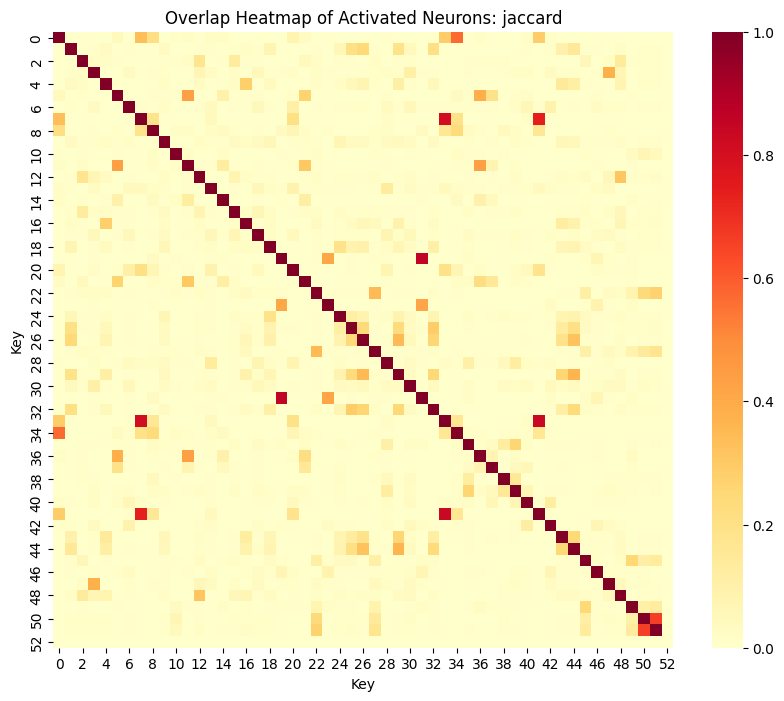

AttributeError: 'list' object has no attribute 'items'

In [169]:
## 🐸baseline

lang_prompt="id-ID"
max_instances = 50
infer_model = massive_qwen
lape_langs = lape_massive_qwen_2 
range_layers = range(18,24)
# scores, b_avg_score, b_acc, b_ppl = get_ppl_massive_w_target(infer_model, max_instances, lang_prompt=lang_prompt,  lape_langs=lape_langs, target_lang=None, 
#                             operation_non_target=None, operation_target=None, 
#                             max_new_tokens=10, range_layers=range_layers, replace_method="lape")

##🐸🐸ABLATED
##🐸2%

operation_non_target = "=0"
operation_target = "*1"


intv_scores_massive_qwen = dict()
intv_scores_massive_qwen['baseline'] = (b_acc, b_ppl, b_avg_score) 



scores, avg_score, acc, ppl = get_ppl_massive_w_target(infer_model, max_instances, lang_prompt=lang_prompt,lape_langs=lape_langs, target_lang=19, 
                            operation_non_target=operation_non_target, operation_target=operation_target, 
                            max_new_tokens=20, range_layers=range_layers, replace_method="lape")

print(f"avg_score intervention indonesian prompt with 2% LAPE on indonesian neurons: {avg_score}")
intv_scores_massive_qwen["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive_w_target(infer_model, max_instances, lang_prompt=lang_prompt, lape_langs=lape_langs, target_lang=31, 
                            operation_non_target=operation_non_target, operation_target=operation_target, 
                            max_new_tokens=20, range_layers=range_layers, replace_method="lape")
print(f"avg_score intervention indonesian prompt with 2% LAPE on malaysian neurons: {avg_score}")
intv_scores_massive_qwen["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive_w_target(infer_model, max_instances, lang_prompt=lang_prompt, lape_langs=lape_langs, target_lang=23, 
                            operation_non_target=operation_non_target, operation_target=operation_target, 
                            max_new_tokens=20, range_layers=range_layers, replace_method="lape")
print(f"avg_score intervention indonesian prompt with 2% LAPE on javanese neurons: {avg_score}")
intv_scores_massive_qwen["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive_w_target(infer_model, max_instances, lang_prompt=lang_prompt, lape_langs=lape_langs, target_lang=49, 
                            operation_non_target=operation_non_target, operation_target=operation_target, 
                            max_new_tokens=20, range_layers=range_layers, replace_method="lape")
print(f"avg_score intervention indonesian prompt with 2% LAPE on vietnamese neurons: {avg_score}")
intv_scores_massive_qwen["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive_w_target(infer_model, max_instances, lang_prompt=lang_prompt, lape_langs=lape_langs, target_lang=10, 
                            operation_non_target=operation_non_target, operation_target=operation_target, 
                            max_new_tokens=20, range_layers=range_layers, replace_method="lape")
print(f"avg_score intervention indonesian prompt with 2% LAPE on english neurons: {avg_score}")
intv_scores_massive_qwen["en"] = (acc, ppl, avg_score)


##🐸🐸ABLATED
##🐸5%
lape_massive_qwen_5 = visualize_lape(full_languages_raw_values, 24, top_rate = 0.05,filter_rate=0.80,activation_bar_ratio=0.80)

intv_scores_massive_qwen_5 = dict()
intv_scores_massive_qwen_5['baseline'] = (b_acc, b_ppl, b_avg_score) 


lape_langs = {key:lape_massive_qwen_5[key] for key, value in enumerate(lape_massive_qwen_5)}

# lape_langs = lape_massive_qwen_5
percent = 5

scores, avg_score, acc, ppl = get_ppl_massive_w_target(infer_model, max_instances, lang_prompt=lang_prompt, lape_langs=lape_langs, target_lang=19, 
                            operation_non_target=operation_non_target, operation_target=operation_target, 
                            max_new_tokens=20, range_layers=range_layers, replace_method="lape")
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on indonesian neurons: {avg_score}")
intv_scores_massive_qwen_5["id"] = (acc, ppl, avg_score)
scores, avg_score, acc, ppl = get_ppl_massive_w_target(infer_model, max_instances, lang_prompt=lang_prompt, lape_langs=lape_langs, target_lang=31, 
                            operation_non_target=operation_non_target, operation_target=operation_target, 
                            max_new_tokens=20, range_layers=range_layers, replace_method="lape")
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on malaysian neurons: {avg_score}")
intv_scores_massive_qwen_5["my"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive_w_target(infer_model, max_instances, lang_prompt=lang_prompt, lape_langs=lape_langs, target_lang=23, 
                            operation_non_target=operation_non_target, operation_target=operation_target, 
                            max_new_tokens=20, range_layers=range_layers, replace_method="lape")
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on javanese neurons: {avg_score}")
intv_scores_massive_qwen_5["jv"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive_w_target(infer_model, max_instances, lang_prompt=lang_prompt, lape_langs=lape_langs, target_lang=49, 
                            operation_non_target=operation_non_target, operation_target=operation_target, 
                            max_new_tokens=20, range_layers=range_layers, replace_method="lape")
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on vietnamese neurons: {avg_score}")
intv_scores_massive_qwen_5["vi"] = (acc, ppl, avg_score)


scores, avg_score, acc, ppl = get_ppl_massive_w_target(infer_model, max_instances, lang_prompt=lang_prompt, lape_langs=lape_langs, target_lang=10, 
                            operation_non_target=operation_non_target, operation_target=operation_target, 
                            max_new_tokens=20, range_layers=range_layers, replace_method="lape")
print(f"avg_score intervention indonesian prompt with {percent}% LAPE on english neurons: {avg_score}")
intv_scores_massive_qwen_5["en"] = (acc, ppl, avg_score)

lape_2_values = []
for key, val in intv_scores_massive_qwen.items():
    lape_2_values.append(val)
lape_2_values


lape_5_values = []
for key, val in intv_scores_massive_qwen_5.items():
    lape_5_values.append(val)
lape_5_values
df["LAPE 2%"] = lape_2_values
df["LAPE 5%"] = lape_5_values



In [171]:
lape_2_values = []
for key, val in intv_scores_massive_qwen.items():
    lape_2_values.append(val)
lape_2_values
df["LAPE 2%"] = lape_2_values


In [172]:
df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,intervention,LAPE 1%,LAPE 2%,LAPE 5%,Manually Set Differenced,Distribution Method max,Distribution Method > 99th percentile,Spearman Rho
0,baseline,NaN,"(0.94, 1.8460786843299866, 0.4491238867666068)",NaN,NaN,NaN,NaN,NaN
1,indo,NaN,"(0.26, 4.933073465824127, 0.13213712696982902)",NaN,NaN,NaN,NaN,NaN
2,malay,NaN,"(0.26, 4.933073465824127, 0.13213712696982902)",NaN,NaN,NaN,NaN,NaN
3,java,NaN,"(0.26, 4.933073465824127, 0.13337699624561372)",NaN,NaN,NaN,NaN,NaN
4,vietnam,NaN,"(0.26, 4.937612035274506, 0.13212660304381016)",NaN,NaN,NaN,NaN,NaN
5,eng,NaN,"(0.26, 4.932482883930207, 0.13215533804054863)",NaN,NaN,NaN,NaN,NaN
